In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA  

In [56]:
data = pd.read_csv("/Users/seydanurkayir/Desktop/iyzico-datathon/train.csv")
data.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428


In [54]:
data[["Merchant", "ID"]] = data["merchant_id"].str.split("_", expand=True)
train = data.drop(['merchant_id','Merchant','merchant_source_name','settlement_period',
                      'working_type','mcc_id','merchant_segment'], axis=1)
train.head()

,month_id,net_payment_count,ID
0,202307,15106,43992
1,202301,16918,43992
2,202305,13452,43992
3,202308,16787,43992
4,202302,12428,43992


In [57]:
#train = data.drop(['merchant_source_name','settlement_period',
                      'working_type','mcc_id','merchant_segment'], axis=1)
#train.head()

,merchant_id,month_id,net_payment_count
0,merchant_43992,202307,15106
1,merchant_43992,202301,16918
2,merchant_43992,202305,13452
3,merchant_43992,202308,16787
4,merchant_43992,202302,12428


In [58]:
train = train.sort_values(by=['#', 'month_id'])
train.head(10)


,merchant_id,month_id,net_payment_count
234370,merchant_1,202108,3
234371,merchant_1,202210,3
249229,merchant_10,202111,6
249226,merchant_10,202112,24
249224,merchant_10,202201,15
249225,merchant_10,202202,7
249227,merchant_10,202203,9
249228,merchant_10,202204,4
269591,merchant_10000,202205,3
269590,merchant_10000,202206,4


In [59]:
train['month_id'] = pd.to_datetime(train['month_id'], format='%Y%m').dt.strftime('%Y-%m')
train['ID'] = train['ID'].astype('int')
train['month_id'] = pd.to_datetime(train['month_id'], format='%Y-%m').dt.tz_localize(None)

train.info()

ValueError: invalid literal for int() with base 10: 'merchant_1'

In [6]:
# Tüm ayları içeren bir tam zaman serisi oluşturun
full_months = pd.date_range(start=train['month_id'].min().replace(day=1), end=train['month_id'].max().replace(day=1), freq='MS')

# Her bir ID için bütün ayları içeren genişletilmiş DataFrame oluşturun
new_df = pd.DataFrame({'month_id': [], 'ID': []})
for id in train['ID'].unique():
    id_df = pd.DataFrame({'month_id': full_months, 'ID': id})
    new_df = pd.concat([new_df, id_df])

# Mevcut veri setini genişletilmiş DataFrame ile birleştirin
merge_df = pd.merge(new_df, train, on=['month_id', 'ID'], how='left')

# NaN değerleri 0 olarak doldurun
merge_df['net_payment_count'] = merge_df['net_payment_count'].fillna(0)

# Sonuçları göster
print(merge_df)

          month_id      ID  net_payment_count
0       2020-01-01     1.0                0.0
1       2020-02-01     1.0                0.0
2       2020-03-01     1.0                0.0
3       2020-04-01     1.0                0.0
4       2020-05-01     1.0                0.0
...            ...     ...                ...
1172695 2023-05-01  9993.0                0.0
1172696 2023-06-01  9993.0                4.0
1172697 2023-07-01  9993.0                0.0
1172698 2023-08-01  9993.0                0.0
1172699 2023-09-01  9993.0                0.0

[1172700 rows x 3 columns]


In [7]:
merge_df['ID'] = merge_df['ID'].astype('int')
merge_df['net_payment_count'] = merge_df['net_payment_count'].astype('int')


In [8]:
merge_df.set_index('month_id', inplace=True)

merge_df.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01',
               ...
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01'],
              dtype='datetime64[ns]', name='month_id', length=1172700, freq=None)

In [16]:
merge_df.head()

,ID,net_payment_count
month_id,,
2020-01-01,1,0
2020-02-01,1,0
2020-03-01,1,0
2020-04-01,1,0
2020-05-01,1,0


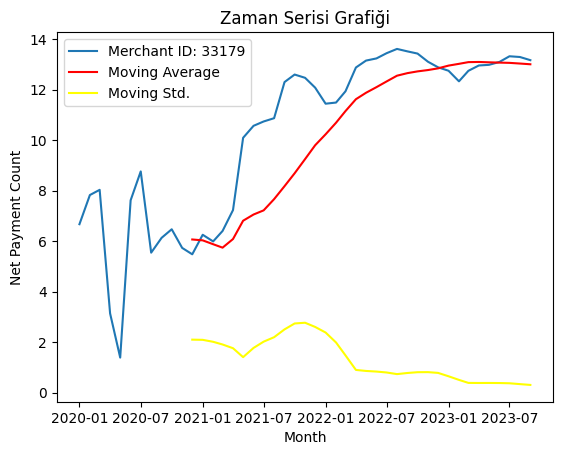

In [10]:
def plot_merchant(merge_df, id):
    data = merge_df[merge_df['ID'] == id]
    merchant_data = data.sort_values(by=['month_id'])
    
    ts_log = np.log(merchant_data['net_payment_count'])
    moving_avg = ts_log.rolling(12).mean()
    moving_std = ts_log.rolling(12).std()
    #plt.plot(ts, color='red')
    plt.plot(ts_log, label=f'Merchant ID: {id}')
    plt.plot(moving_avg, color='red', label='Moving Average')
    plt.plot(moving_std, color='yellow', label='Moving Std.')

    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')
    plt.title('Zaman Serisi Grafiği')

    plt.show()


plot_merchant(merge_df,33179)

/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID 33179:

                 Forecast
2023-10-01  556560.545675
2023-11-01  589087.546229
2023-12-01  547880.550622


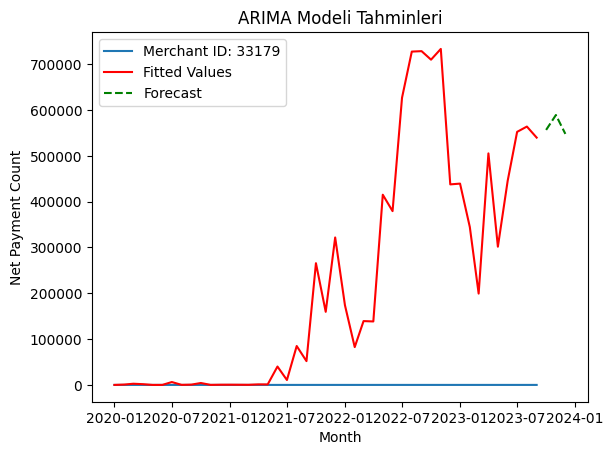

In [11]:
def forecast_merchant(merge_df, id, forecast_periods=3):
    data = merge_df[merge_df['ID'] == id]
    merchant_data = data.sort_values(by=['month_id'])

    ts_log = np.log(merchant_data['net_payment_count'])

    # ARIMA modelini oluşturun ve eğitin
    model = sm.tsa.ARIMA(ts_log, order=(2, 1, 2))  
    results_ARIMA = model.fit()

    # Tahminleri alın
    forecast = results_ARIMA.get_forecast(steps=forecast_periods)

    # Tahminleri indeks ile eşleştirin
    forecast_index = pd.date_range(start=ts_log.index[-1], periods=forecast_periods+1, freq='MS')[1:]
    #forecast_index = forecast_index.strftime('%Y-%m')

    forecast_values = np.exp(forecast.predicted_mean)
    # Tahminleri DataFrame olarak oluşturun
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values,
    }, index=forecast_index)

    # Tahminleri göster
    print(f"Forecast for Merchant ID {id}:\n")
    print(forecast_df)

    # Grafik üzerinde gösterim
    plt.plot(ts_log, label=f'Merchant ID: {id}')
    plt.plot(np.exp(results_ARIMA.fittedvalues), color='red', label='Fitted Values')
    plt.plot(forecast_df, color='green', linestyle='--', label='Forecast')
    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')
    plt.title('ARIMA Modeli Tahminleri')

    plt.show()

# Belirli bir 'id' için 3 aylık tahmin yapın
forecast_merchant(merge_df, 33179, forecast_periods=3)

In [ ]:
def forecast_all_merchants(merge_df, forecast_periods=3):
    unique_ids = merge_df['ID'].unique()

    for merchant_id in unique_ids:
        forecast_merchant(merge_df, merchant_id, forecast_periods)

# Tüm merchant'lar için 3 aylık tahmin yapın
forecast_all_merchants(merge_df, forecast_periods=3)

In [18]:
merge_df['net_payment_count'] = merge_df['net_payment_count'].apply(lambda x: x + 1 if x <= 0 else x)

# Sıfır veya negatif değerlere sahip satırları filtreleme
merge_df = merge_df[merge_df['net_payment_count'] > 0]
ts_log = np.log(merge_df['net_payment_count'])

In [28]:
aaa = pd.DataFrame({
    'net_payment_count': merge_df['net_payment_count'],
    'ID': merge_df['ID']
}, index=merge_df.index)
aaa

,net_payment_count,ID
month_id,,
2020-01-01,1,1
2020-02-01,1,1
2020-03-01,1,1
2020-04-01,1,1
2020-05-01,1,1
...,...,...
2023-05-01,1,9993
2023-06-01,4,9993
2023-07-01,1,9993


In [30]:
ts_log = np.log(aaa['net_payment_count'])
ts_log

month_id
2020-01-01    0.000000
2020-02-01    0.000000
2020-03-01    0.000000
2020-04-01    0.000000
2020-05-01    0.000000
                ...   
2023-05-01    0.000000
2023-06-01    1.386294
2023-07-01    0.000000
2023-08-01    0.000000
2023-09-01    0.000000
Name: net_payment_count, Length: 1172520, dtype: float64

In [31]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

merchant_data = merge_df[merge_df['ID'] == 33179]

data = merchant_data['net_payment_count']
#seasonal = False

model = pm.auto_arima(data, 
                      m=12,               # frequency of series                      
                      seasonal=True,  # TRUE if seasonal series
                      d=1,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=3, max_q=3,   # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

#print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1122.042, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1119.902, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1112.993, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1112.649, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1118.920, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1110.660, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1112.647, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1114.629, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1112.326, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1114.061, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1111.176, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1114.437, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1109.172, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=1111.133, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1

In [51]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -552.586
Date:                Thu, 08 Feb 2024   AIC                           1109.172
Time:                        11:42:33   BIC                           1112.741
Sample:                             0   HQIC                          1110.496
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5240      0.214      2.445      0.014       0.104       0.944
sigma2      5.299e+09   7.61e-12   6.96e+20      0.000     5.3e+09     5.3e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.08
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):            1006.10   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [66]:
ts_log = np.log(merge_df['net_payment_count'])
ts_log

month_id
2020-01-01    0.000000
2020-02-01    0.000000
2020-03-01    0.000000
2020-04-01    0.000000
2020-05-01    0.000000
                ...   
2023-05-01    0.000000
2023-06-01    1.386294
2023-07-01    0.000000
2023-08-01    0.000000
2023-09-01    0.000000
Name: net_payment_count, Length: 1172520, dtype: float64

In [65]:
# Sıfır veya negatif değerleri bir sabit değer ekleyerek düzeltme
merge_df['net_payment_count'] = merge_df['net_payment_count'].apply(lambda x: x + 1 if x <= 0 else x)

# Sıfır veya negatif değerlere sahip satırları filtreleme
merge_df = merge_df[merge_df['net_payment_count'] > 0]
ts_log = np.log(merge_df['net_payment_count'])


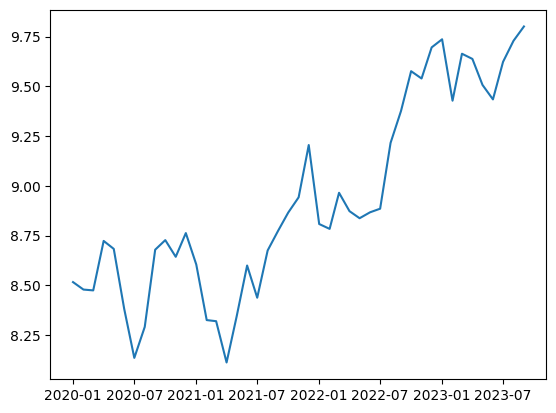

In [68]:
net_payment_count_id = merge_df[merge_df['ID'] == 43992][['net_payment_count']]

df_log = np.log(net_payment_count_id['net_payment_count'] + 1)

plt.plot(df_log)

In [71]:
moving_avg = df_log.rolling(12).mean()
moving_avg

month_id
2020-01-01         NaN
2020-02-01         NaN
2020-03-01         NaN
2020-04-01         NaN
2020-05-01         NaN
2020-06-01         NaN
2020-07-01         NaN
2020-08-01         NaN
2020-09-01         NaN
2020-10-01         NaN
2020-11-01         NaN
2020-12-01    8.541875
2021-01-01    8.549243
2021-02-01    8.536472
2021-03-01    8.523583
2021-04-01    8.472713
2021-05-01    8.444499
2021-06-01    8.462647
2021-07-01    8.487825
2021-08-01    8.519820
2021-09-01    8.527735
2021-10-01    8.539245
2021-11-01    8.564142
2021-12-01    8.600981
2022-01-01    8.617924
2022-02-01    8.656089
2022-03-01    8.709829
2022-04-01    8.773156
2022-05-01    8.814203
2022-06-01    8.836471
2022-07-01    8.873727
2022-08-01    8.918752
2022-09-01    8.968902
2022-10-01    9.028087
2022-11-01    9.077806
2022-12-01    9.118677
2023-01-01    9.195983
2023-02-01    9.249631
2023-03-01    9.307824
2023-04-01    9.371534
2023-05-01    9.427319
2023-06-01    9.474568
2023-07-01    9.536024
20

In [73]:
ts_log_diff = df_log - df_log.shift()
ts_log_diff

month_id
2020-01-01         NaN
2020-02-01   -0.037509
2020-03-01   -0.004163
2020-04-01    0.248436
2020-05-01   -0.040002
2020-06-01   -0.301265
2020-07-01   -0.246064
2020-08-01    0.155572
2020-09-01    0.387685
2020-10-01    0.048134
2020-11-01   -0.083790
2020-12-01    0.119133
2021-01-01   -0.157755
2021-02-01   -0.279171
2021-03-01   -0.005585
2021-04-01   -0.207321
2021-05-01    0.231853
2021-06-01    0.255082
2021-07-01   -0.161696
2021-08-01    0.237368
2021-09-01    0.098733
2021-10-01    0.091268
2021-11-01    0.076856
2021-12-01    0.262435
2022-01-01   -0.396508
2022-02-01   -0.024510
2022-03-01    0.181326
2022-04-01   -0.092287
2022-05-01   -0.035512
2022-06-01    0.029750
2022-07-01    0.018154
2022-08-01    0.330583
2022-09-01    0.160254
2022-10-01    0.199677
2022-11-01   -0.036743
2022-12-01    0.156267
2023-01-01    0.040714
2023-02-01   -0.308405
2023-03-01    0.235855
2023-04-01   -0.026076
2023-05-01   -0.130610
2023-06-01   -0.072674
2023-07-01    0.188630
20

<Axes: xlabel='month_id', ylabel='net_payment_count'>

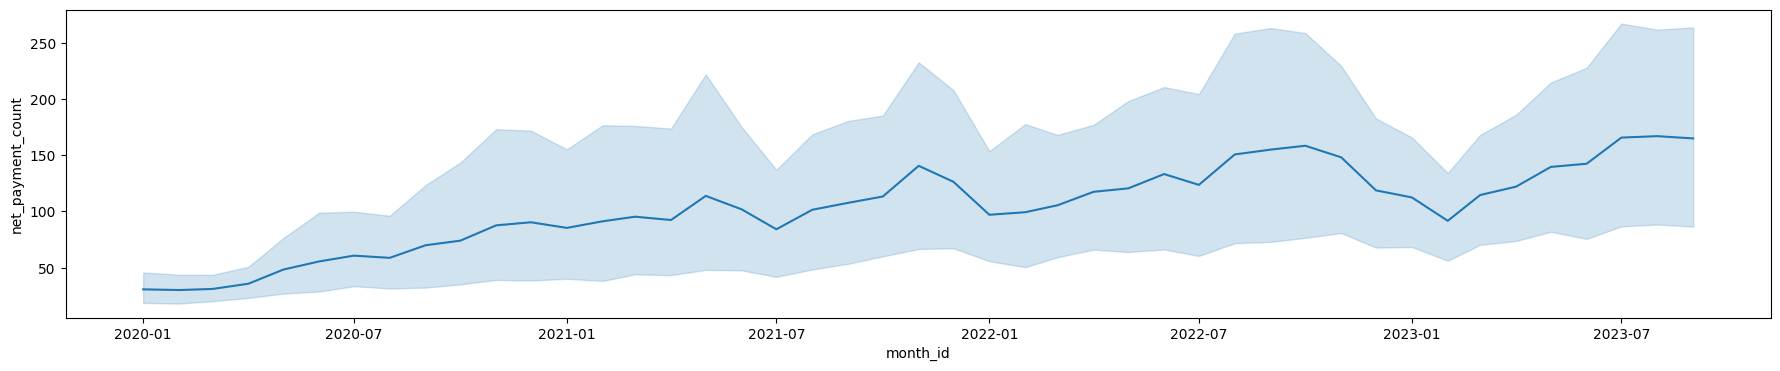

In [76]:
plt.figure(figsize=(22,4))
sns.lineplot(data = merge_df.reset_index(), x="month_id", y="net_payment_count")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(merge_df.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

In [74]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)


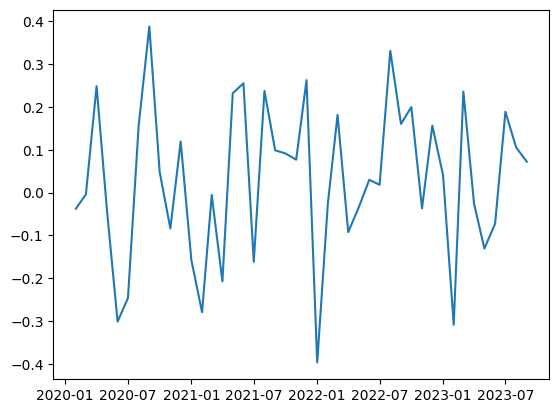

In [46]:
ts_log_diff = df_log - df_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)

In [51]:
train.set_index('month_id', inplace=True)

train.index

KeyError: "None of ['month_id'] are in the columns"

In [41]:
import matplotlib.pyplot as plt


In [46]:
df = train[train['ID'] == 43992].sort_values(by=['month_id'])


<Axes: xlabel='month_id'>

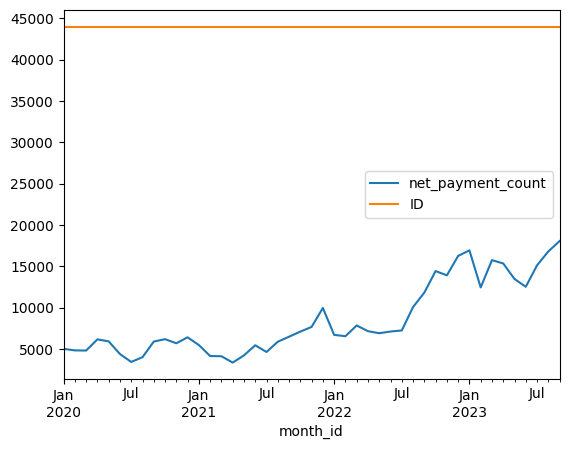

In [48]:
df.plot()


In [47]:
model = sm.tsa.ARIMA(ts_log_diff, order=(0, 1, 1))
results_ARIMA = model.fit()

/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [48]:
forecast = results_ARIMA.get_forecast(steps=3)
forecast_index = pd.date_range(start=ts_log_diff.index[-1], periods=4, freq='MS')[1:]

forecast_values = np.exp(forecast.predicted_mean)
forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
}, index=forecast_index)
print(forecast_df)

            Forecast
2023-10-01  1.029605
2023-11-01  1.029605
2023-12-01  1.029605


2023-10-01    511190.445684
2023-11-01    511190.445684
2023-12-01    511190.445684
Freq: MS, Name: predicted_mean, dtype: float64